In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import numpy as np

In [2]:
# def list_dataset_codes():
api_endpoint = "https://api.ons.gov.uk/"
api_params = 'code-lists'
url = (api_endpoint
                    + api_params)
                        
#     return requests.get(url).json()
    

In [3]:
requests.get(url).json()

'No API is defined for GET /code-lists'

In [4]:
def grab_ONS_time_series_data(dataset_id,timeseries_id):
    """ This function grabs specified time series from the ONS API. """
    api_endpoint = "https://api.ons.gov.uk/"
    api_params = {
    'dataset':dataset_id,
    'timeseries':timeseries_id}
    url = (api_endpoint
                        +'/'.join([x+'/'+y for x,y in zip(api_params.keys(),api_params.values())][::-1])
                        +'/data')
    print(url)
    return requests.get(url).json()

https://api.ons.gov.uk/timeseries/D7G7/dataset/MM23/data
Code output:

CPI ANNUAL RATE 00: ALL ITEMS 2015=100
               label     month quarter sourceDataset  \
date                                                   
1989-01-01  1989 JAN   January                  MM23   
1989-02-01  1989 FEB  February                  MM23   
1989-03-01  1989 MAR     March                  MM23   
1989-04-01  1989 APR     April                  MM23   
1989-05-01  1989 MAY       May                  MM23   

                          updateDate  value  year  
date                                               
1989-01-01  2015-10-12T23:00:00.000Z    4.9  1989  
1989-02-01  2015-10-12T23:00:00.000Z    5.0  1989  
1989-03-01  2015-10-12T23:00:00.000Z    5.0  1989  
1989-04-01  2015-10-12T23:00:00.000Z    5.3  1989  
1989-05-01  2015-10-12T23:00:00.000Z    5.3  1989  


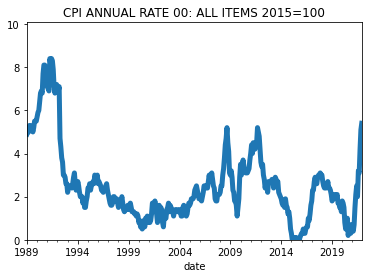

In [93]:
# Grab the data (put your time series codes here) 

data = grab_ONS_time_series_data('MM23','D7G7')

# Check we have the right time series 
title_text = data['description']['title']
print("Code output:\n")
print(title_text)
# Put the data into a dataframe and convert types # Note that you'll need to change months if you're 
# using data at a different frequency 
df = pd.DataFrame(pd.json_normalize(data['months']))
# Put the data in a standard datetime format
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype(float)
df = df.set_index('date')
# Check the data look sensible 
print(df.head())
# Plot the data 
df['value'].plot(title=title_text,ylim=(0,df['value'].max()*1.2),lw=5.)
plt.show()

In [94]:
#--- select just the values needed for the model
df = df[['value']]
df.head()

,value
date,
1989-01-01,4.9
1989-02-01,5.0
1989-03-01,5.0
1989-04-01,5.3
1989-05-01,5.3


In [107]:
#--- split into train and test
# df = df.reset_index(drop = True)

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n*0.7)][['value']]
val_df = df[int(n*0.7):int(n*0.9)][['value']]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

1

In [108]:
train_mean = train_df['value'].mean()
train_std = train_df['value'].std()

train_df.value = (train_df.value-train_mean)/train_std
val_df.value = (val_df.value-train_mean)/train_std
test_df.value = (test_df.value-train_mean)/train_std

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
class WindowGenerator():
    def __init__(self, 
                 input_width,
                 label_width,
                 shift,
                 train_df,
                 val_df,
                 test_df, 
                 label_columns = None):
        
        #--store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #--workout label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #Work out the window parameters
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
                                 
                                 
    def split_window(self, features):
        inputs = features[:,self.input_slice,:]
        labels = features[:,self.label_slice,:]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis = -1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data,
        targets = None,
        sequence_length = self.total_window_size,
        sequence_stride = 1,
        shuffle = False,
        batch_size = 32,
        )

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)   

In [112]:
single_step_window = WindowGenerator(
input_width = 1,
label_width = 1,
shift = 1,
train_df = train_df,
val_df = val_df,
test_df = test_df,
label_columns = ['value']
)

In [113]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index = None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:,:,self.label_index]
        return result[:,:, tf.newaxis]

In [114]:
baseline = Baseline(label_index = column_indices['value'])
baseline.compile(loss = tf.losses.MeanSquaredError(),
                metrics = [tf.metrics.MeanAbsoluteError()])


In [92]:
val_df

<TensorSliceDataset shapes: ((),), types: (tf.float32,)>

In [115]:
val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# val_performance['Baseline_other'] = baseline.evaluate(val)
val_performance

3/3 [==============================] - 0s 8ms/step - loss: 0.0153 - mean_absolute_error: 0.0953


{'Baseline': [0.015284225344657898, 0.09529442340135574]}

In [116]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [117]:
single_step_window.val

<MapDataset shapes: ((None, 1, 1), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [121]:
pred = baseline.predict(single_step_window.train)

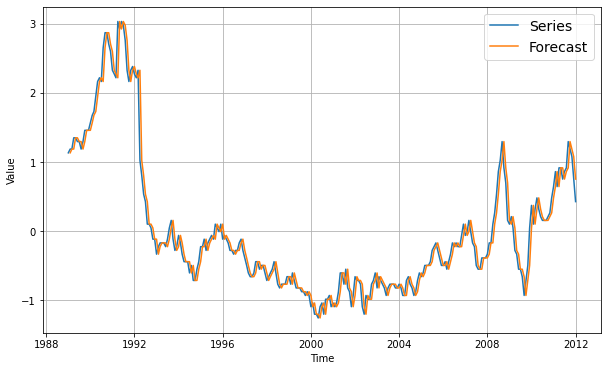

In [123]:
#plot test and validaion predictions
plt.figure(figsize=(10, 6))
plot_series(train_df.index, train_df.value, label="Series")
plot_series(train_df.index[1:], pred.reshape(-1,), label="Forecast")

In [124]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

linear.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])

linear.fit(single_step_window.train, epochs = 3, validation_data =single_step_window.val )

Epoch 1/3
9/9 [==============================] - 1s 31ms/step - loss: 3.4825 - mean_absolute_error: 1.4149 - val_loss: 2.3507 - val_mean_absolute_error: 1.1288
Epoch 2/3
9/9 [==============================] - 0s 17ms/step - loss: 3.4605 - mean_absolute_error: 1.4108 - val_loss: 2.3389 - val_mean_absolute_error: 1.1260
Epoch 3/3
9/9 [==============================] - 0s 19ms/step - loss: 3.4415 - mean_absolute_error: 1.4070 - val_loss: 2.3267 - val_mean_absolute_error: 1.1232


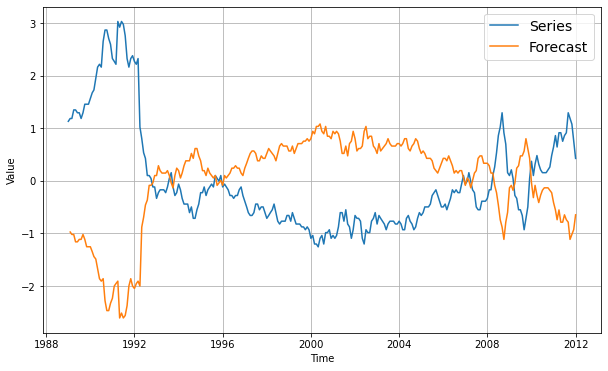

In [126]:
pred = linear.predict(single_step_window.train)
plt.figure(figsize=(10, 6))
plot_series(train_df.index, train_df.value, label="Series")
plot_series(train_df.index[1:], pred.reshape(-1,), label="Forecast")

In [125]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

val_performance

3/3 [==============================] - 0s 7ms/step - loss: 2.3267 - mean_absolute_error: 1.1232


{'Baseline': [0.015284225344657898, 0.09529442340135574],
 'Linear': [2.3267390727996826, 1.123155951499939]}

In [127]:
def compile_and_fit(model, window, patience=1):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                    patience = patience,
                                                    mode = 'min')
    model.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])
    
    model.fit(window.train, 
              epochs = MAX_EPOCHS, 
              validation_data =window.val,
             callbacks = [early_stopping])
    

In [128]:
MAX_EPOCHS = 28

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation = 'relu'),
    tf.keras.layers.Dense(units=64, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])
compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)

val_performance

Epoch 1/28
9/9 [==============================] - 1s 54ms/step - loss: 0.9260 - mean_absolute_error: 0.6837 - val_loss: 0.3719 - val_mean_absolute_error: 0.4486
Epoch 2/28
9/9 [==============================] - 0s 41ms/step - loss: 0.5631 - mean_absolute_error: 0.5372 - val_loss: 0.2463 - val_mean_absolute_error: 0.3666
Epoch 3/28
9/9 [==============================] - 0s 39ms/step - loss: 0.3485 - mean_absolute_error: 0.4162 - val_loss: 0.1470 - val_mean_absolute_error: 0.2877
Epoch 4/28
9/9 [==============================] - 0s 43ms/step - loss: 0.2042 - mean_absolute_error: 0.3115 - val_loss: 0.0790 - val_mean_absolute_error: 0.2182
Epoch 5/28
9/9 [==============================] - 0s 41ms/step - loss: 0.1154 - mean_absolute_error: 0.2306 - val_loss: 0.0418 - val_mean_absolute_error: 0.1675
Epoch 6/28
9/9 [==============================] - 0s 41ms/step - loss: 0.0682 - mean_absolute_error: 0.1821 - val_loss: 0.0275 - val_mean_absolute_error: 0.1390
Epoch 7/28
9/9 [==================

{'Baseline': [0.015284225344657898, 0.09529442340135574],
 'Linear': [2.3267390727996826, 1.123155951499939],
 'Dense': [0.023969223722815514, 0.12755344808101654]}

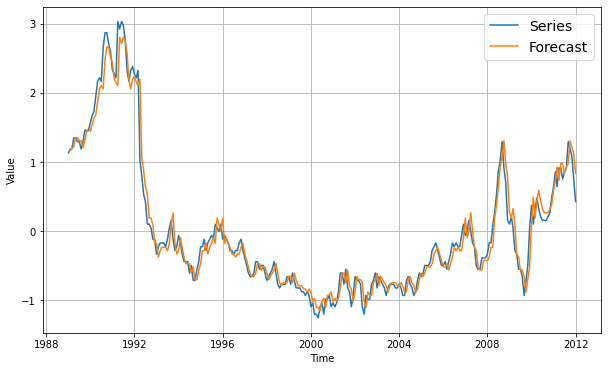

In [129]:
pred = dense.predict(single_step_window.train)
plt.figure(figsize=(10, 6))
plot_series(train_df.index, train_df.value, label="Series")
plot_series(train_df.index[1:], pred.reshape(-1,), label="Forecast")

In [130]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
input_width = CONV_WIDTH,
label_width = 1,
shift = 1,
train_df=train_df,
val_df=val_df,
test_df=test_df,
label_columns=['value'])

conv_model =  tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH,),
                           activation = 'relu'),
    tf.keras.layers.Dense(units=32, activation = 'relu'),
    tf.keras.layers.Dense(units=1),
])

compile_and_fit(conv_model, conv_window)
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

val_performance

Epoch 1/28
9/9 [==============================] - 1s 59ms/step - loss: 0.8579 - mean_absolute_error: 0.7410 - val_loss: 0.8212 - val_mean_absolute_error: 0.6668
Epoch 2/28
9/9 [==============================] - 0s 40ms/step - loss: 0.6213 - mean_absolute_error: 0.6350 - val_loss: 0.6582 - val_mean_absolute_error: 0.5962
Epoch 3/28
9/9 [==============================] - 0s 44ms/step - loss: 0.4620 - mean_absolute_error: 0.5507 - val_loss: 0.5357 - val_mean_absolute_error: 0.5376
Epoch 4/28
9/9 [==============================] - 0s 34ms/step - loss: 0.3419 - mean_absolute_error: 0.4794 - val_loss: 0.4435 - val_mean_absolute_error: 0.4901
Epoch 5/28
9/9 [==============================] - 0s 42ms/step - loss: 0.2507 - mean_absolute_error: 0.4160 - val_loss: 0.3617 - val_mean_absolute_error: 0.4445
Epoch 6/28
9/9 [==============================] - 0s 36ms/step - loss: 0.1846 - mean_absolute_error: 0.3589 - val_loss: 0.2923 - val_mean_absolute_error: 0.4020
Epoch 7/28
9/9 [==================

{'Baseline': [0.015284225344657898, 0.09529442340135574],
 'Linear': [2.3267390727996826, 1.123155951499939],
 'Dense': [0.023969223722815514, 0.12755344808101654],
 'Conv': [0.03049401007592678, 0.14741328358650208]}

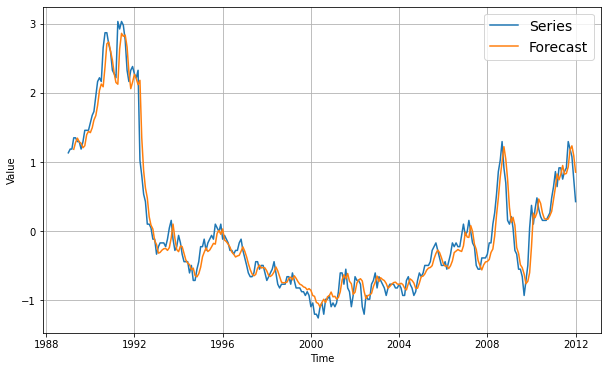

In [133]:
pred = conv_model.predict(conv_window.train)
plt.figure(figsize=(10, 6))
plot_series(train_df.index, train_df.value, label="Series")
plot_series(train_df.index[3:], pred.reshape(-1,), label="Forecast")

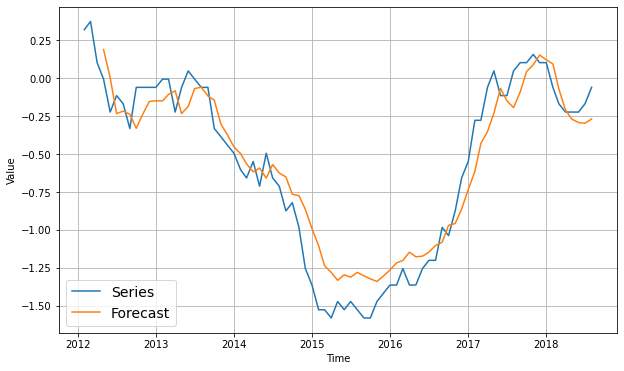

In [166]:
pred = conv_model.predict(conv_window.val)
plt.figure(figsize=(10, 6))
plot_series(val_df.index, val_df.value, label="Series")
plot_series(val_df.index[3:], pred.reshape(-1,), label="Forecast")

In [138]:
#RNN V LSTM

lstm =  tf.keras.Sequential([
    tf.keras.layers.LSTM(32,return_sequences = True),
    tf.keras.layers.Dense(units=1),
])


wide_window = WindowGenerator(
input_width = 12,
label_width = 12,
shift = 1,
train_df=train_df,
val_df=val_df,
test_df=test_df, 
    label_columns=['value'])

compile_and_fit(lstm,wide_window)

val_performance['LSTM'] = lstm.evaluate(wide_window.val)

val_performance

Epoch 1/28
9/9 [==============================] - 4s 100ms/step - loss: 1.5466 - mean_absolute_error: 0.9440 - val_loss: 1.2296 - val_mean_absolute_error: 0.8482
Epoch 2/28
9/9 [==============================] - 0s 52ms/step - loss: 1.3638 - mean_absolute_error: 0.8834 - val_loss: 1.0802 - val_mean_absolute_error: 0.7943
Epoch 3/28
9/9 [==============================] - 0s 42ms/step - loss: 1.2231 - mean_absolute_error: 0.8313 - val_loss: 0.9518 - val_mean_absolute_error: 0.7451
Epoch 4/28
9/9 [==============================] - 0s 45ms/step - loss: 1.1013 - mean_absolute_error: 0.7838 - val_loss: 0.8412 - val_mean_absolute_error: 0.7008
Epoch 5/28
9/9 [==============================] - 0s 47ms/step - loss: 0.9936 - mean_absolute_error: 0.7396 - val_loss: 0.7449 - val_mean_absolute_error: 0.6596
Epoch 6/28
9/9 [==============================] - 0s 52ms/step - loss: 0.8970 - mean_absolute_error: 0.6975 - val_loss: 0.6603 - val_mean_absolute_error: 0.6218
Epoch 7/28
9/9 [=================

{'Baseline': [0.015284225344657898, 0.09529442340135574],
 'Linear': [2.3267390727996826, 1.123155951499939],
 'Dense': [0.023969223722815514, 0.12755344808101654],
 'Conv': [0.03049401007592678, 0.14741328358650208],
 'LSTM': [0.20108388364315033, 0.331720232963562]}

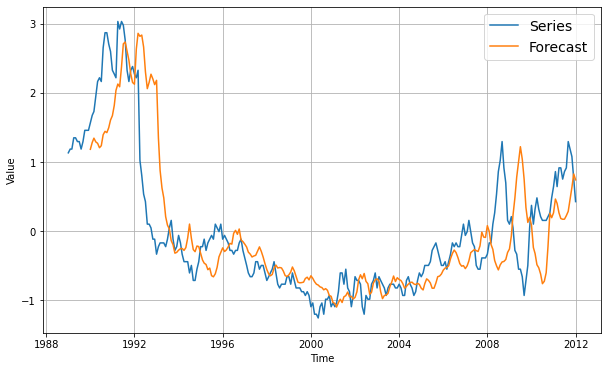

In [151]:
pred = conv_model.predict(wide_window.train)
plt.figure(figsize=(10, 6))
plot_series(train_df.index, train_df.value, label="Series")
plot_series(train_df.index[12:], pred[:,0,0], label="Forecast")

In [159]:
for x,y in wide_window.train:
    print(x.numpy().shape)
    print(y.numpy().shape)

(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(32, 12, 1)
(9, 12, 1)
(9, 12, 1)


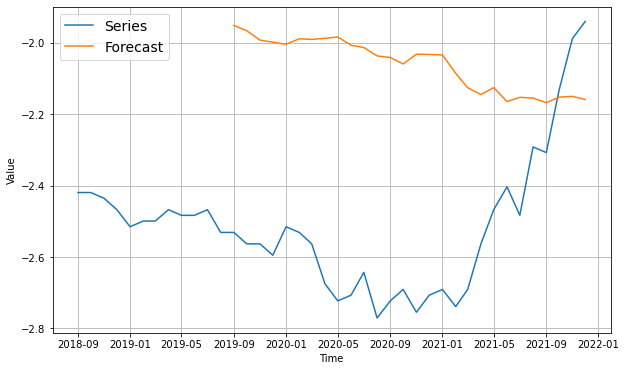

In [161]:
pred= conv_model.predict(wide_window.test)
plt.figure(figsize=(10, 6))
plot_series(test_df.index, test_df.value, label="Series")
plot_series(test_df.index[12:], pred[:,0,0], label="Forecast")

In [163]:
pred.shape

(28, 10, 1)

In [164]:
test_df.shape

(40, 1)

In [167]:
from tensorflow_probability import sts

In [171]:
new_train = sts.regularize_series(
    train_df.value, frequency=None, warn_missing_tolerance=None, err_missing_tolerance=None,
    max_series_length=None
)

In [172]:
new_train

date
1989-01-01    1.132700
1989-02-01    1.186955
1989-03-01    1.186955
1989-04-01    1.349721
1989-05-01    1.349721
                ...   
2011-09-01    1.295466
2011-10-01    1.186955
2011-11-01    1.078445
2011-12-01    0.752914
2012-01-01    0.427382
Freq: <DateOffset: months=1>, Name: value, Length: 277, dtype: float64

In [173]:
autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=new_train,
      name='autoregressive')


In [175]:
demand_forecast_dist = sts.forecast(
    model=autoregressive,
    observed_time_series=new_train,
    num_steps_forecast=1)

TypeError: forecast() missing 1 required positional argument: 'parameter_samples'